First few rows of the dataset:


,CustomerID,Age,Gender,Income,Tenure,LastPurchase,TotalPurchases,TotalSpend,IsReturning,EngagementScore,NextPurchase
0,1,56,Female,75427.0,6,95,14,791.53,0,999,1
1,2,69,Male,47649.0,5,149,7,8329.86,0,43,0
2,3,46,Male,32402.0,1,289,20,1327.39,1,46,1
3,4,32,Female,122880.0,0,257,32,393.70,1,89,0
4,5,60,Male,139764.0,9,184,46,736.62,1,43,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       10000 non-null  int64  
 1   Age              10000 non-null  int64  
 2   Gender           9021 non-null   object 
 3   Income           9500 non-null   float64
 4   Tenure           10000 non-null  int64  
 5   LastPurchase     10000 non-null  int64  
 6   TotalPurchases   10000 non-null  int64  
 7   TotalSpend       9500 non-null   float64
 8   IsReturning      10000 non-null  int64  
 9   EngagementScore  10000 non-null  int64  
 10  NextPurchase     10000 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 859.5+ KB


None

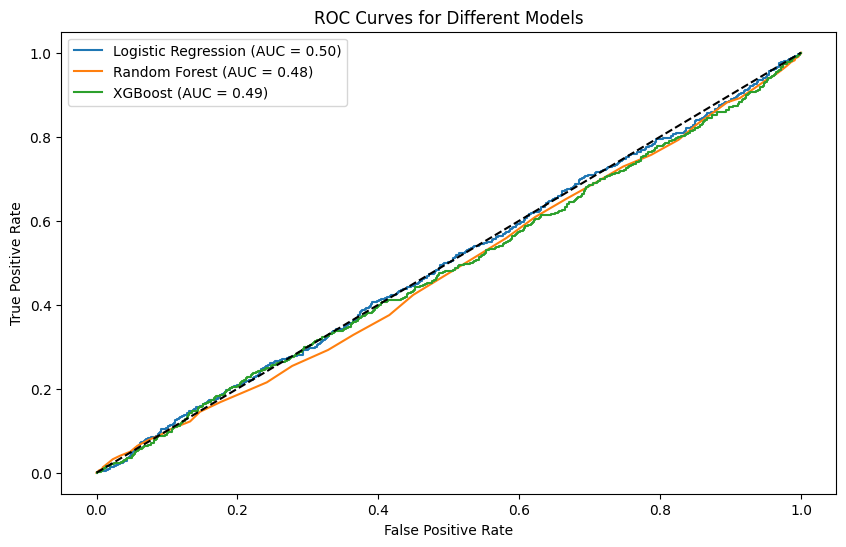

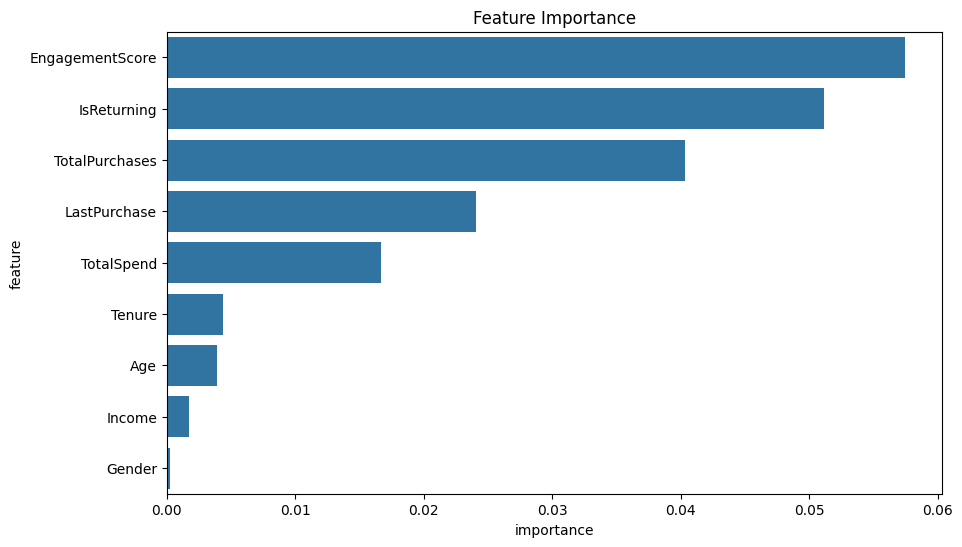

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Install required packages
!pip install xgboost scikit-learn pandas numpy seaborn matplotlib

# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import pickle

# read data
data = pd.read_csv("/content/E-commerce Customer Dataset.csv")

def analyze_and_preprocess():
    # Create a copy of the data
    processed_data = data.copy()

    # Convert Gender to numeric
    le = LabelEncoder()
    processed_data['Gender'] = le.fit_transform(processed_data['Gender'])

    # Handle missing values
    numerical_cols = ['Age', 'Income', 'Tenure', 'LastPurchase', 'TotalPurchases', 'TotalSpend', 'EngagementScore']
    processed_data[numerical_cols] = processed_data[numerical_cols].fillna(processed_data[numerical_cols].mean())

    # Handle outliers
    for col in numerical_cols:
        Q1 = processed_data[col].quantile(0.25)
        Q3 = processed_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        processed_data[col] = processed_data[col].clip(lower_bound, upper_bound)

    # Scale features
    scaler = StandardScaler()
    features_to_scale = processed_data.drop(['CustomerID', 'NextPurchase'], axis=1)
    scaled_features = scaler.fit_transform(features_to_scale)

    return pd.DataFrame(scaled_features, columns=features_to_scale.columns)


def train_and_compare_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': xgb.XGBClassifier()
    }

    results = {}
    for name, model in models.items():
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        results[name] = {
            'model': model,
            'cv_scores': cv_scores,
            'y_pred': y_pred,
            'y_prob': y_prob,
            'roc_data': (fpr, tpr, roc_auc)
        }

    return results, X_test, y_test

def analyze_feature_importance(best_model, feature_names):
    if hasattr(best_model, 'feature_importances_'):
        importance = best_model.feature_importances_
    else:
        importance = np.abs(best_model.coef_[0])

    return pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

def generate_insights(data, model_results):
    insights = {
        'customer_segments': {
            'high_value': data[data['TotalSpend'] > data['TotalSpend'].quantile(0.75)],
            'churning': data[data['LastPurchase'] > data['LastPurchase'].quantile(0.75)]
        },
        'purchase_patterns': {
            'avg_purchase_frequency': data['TotalPurchases'].mean() / data['Tenure'].mean(),
            'retention_rate': (data['IsReturning'] == 1).mean()
        }
    }
    return insights

def export_results(best_model, insights, cv_scores):
    # Save model
    with open('best_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    # Generate summary report
    report = f"""
    E-commerce Customer Analysis Summary Report

    1. Model Performance
    - Best performing model: {best_model.__class__.__name__}
    - Cross-validation accuracy: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})

    2. Key Business Insights
    - Average purchase frequency: {insights['purchase_patterns']['avg_purchase_frequency']:.2f} purchases per year
    - Customer retention rate: {insights['purchase_patterns']['retention_rate']:.2%}

    3. Recommendations
    - Focus on high-value customer retention
    - Implement targeted marketing for churning customers
    - Enhance engagement for low-activity customers
    """

    with open('summary_report.txt', 'w') as f:
        f.write(report)

# Main execution
print("First few rows of the dataset:")
display(data.head())
print("\nDataset Info:")
display(data.info())

# Preprocess data
X = analyze_and_preprocess()
y = data['NextPurchase']

# Train and evaluate models
model_results, X_test, y_test = train_and_compare_models(X, y)

# Plot ROC curves
plt.figure(figsize=(10, 6))
for name, results in model_results.items():
    fpr, tpr, roc_auc = results['roc_data']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend()
plt.show()

# Get best model
best_model_name = max(model_results.items(),
                     key=lambda x: x[1]['roc_data'][2])[0]
best_model = model_results[best_model_name]['model']
cv_scores = model_results[best_model_name]['cv_scores']

# Feature importance
feature_importance = analyze_feature_importance(best_model, X.columns)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()

# Generate insights and save results
insights = generate_insights(data, model_results)
export_results(best_model, insights, cv_scores)

# Download files
files.download('best_model.pkl')
files.download('summary_report.txt')